<a href="https://colab.research.google.com/github/cheongyeechian/DLI/blob/main/chong_jia_wen_tp073941.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LBP Hyperfast Hybrid (with τ-sweep & optional class-weight sweep)

**Goal:** Beat the paper's metrics (Acc≈94.1, Prec≈94.12, Rec≈95.35, F1≈94.73) in under ~5 minutes on CPU.

**Pipeline:**
1) **Stage A** — Fast Linear Prior: Character n-gram `HashingVectorizer` + `SGDClassifier (log_loss)` + Platt scaling.
2) **Stage B** — LBP-lite on **uncertain** subset only: Compact URL↔Domain↔TokenBucket graph with min-sum BP for a few iterations.

**New in this notebook:**
- Prints **training time** (vectorization, model train, calibrator) and **testing time** (Stage A prediction, graph build, LBP, stitching, total).
- **τ-sweep** on a small validation split to auto-pick the best decision threshold for LBP cost ratio.
- **Optional** lightweight **class-weight sweep** for the positive class (phishing). Disabled by default to meet time budget; enable in `CONFIG` if needed.

**Expected files:**
- `/mnt/data/Train_data.csv` (1.2M rows)
- `/mnt/data/Test_data.csv`  (361k rows)

Columns expected: `url`, `label` where label is `good`/`bad` or `0`/`1`.

In [ ]:
# ==========================
# Config
# ==========================

import numpy as np

CONFIG = {
    # Vectorizer & model
    "char_ngram_range": (2,6),   # 扩大 ngram 范围
    "n_features": 2**22,         # 更高维度特征
    "sgd_alpha": 1e-6,           # 更小正则化
    "random_state": 42,

    # Splits
    "valid_size": 0.1,           # validation 更大
    "calib_size": 0.05,          # calibration 更大

    # Uncertain window for handing off to LBP-lite
    "uncertain_low": 0.40,
    "uncertain_high": 0.60,

    # LBP-lite
    "lbp_iters": 12,             # 更多迭代
    "ths_plus": 0.7,             # 可以 sweep
    "ths_minus": 0.9,

    # Tau sweep (validation only)
    "enable_tau_sweep": True,
    "tau_grid": [round(x,2) for x in np.arange(0.3,0.71,0.01)],

    # Class-weight sweep
    "enable_class_weight_sweep": False,
    "pos_weight_grid": 3.0,
}

CONFIG

{'char_ngram_range': (2, 6),
 'n_features': 4194304,
 'sgd_alpha': 1e-06,
 'random_state': 42,
 'valid_size': 0.1,
 'calib_size': 0.05,
 'uncertain_low': 0.4,
 'uncertain_high': 0.6,
 'lbp_iters': 12,
 'ths_plus': 0.7,
 'ths_minus': 0.9,
 'enable_tau_sweep': True,
 'tau_grid': [np.float64(0.3),
  np.float64(0.31),
  np.float64(0.32),
  np.float64(0.33),
  np.float64(0.34),
  np.float64(0.35),
  np.float64(0.36),
  np.float64(0.37),
  np.float64(0.38),
  np.float64(0.39),
  np.float64(0.4),
  np.float64(0.41),
  np.float64(0.42),
  np.float64(0.43),
  np.float64(0.44),
  np.float64(0.45),
  np.float64(0.46),
  np.float64(0.47),
  np.float64(0.48),
  np.float64(0.49),
  np.float64(0.5),
  np.float64(0.51),
  np.float64(0.52),
  np.float64(0.53),
  np.float64(0.54),
  np.float64(0.55),
  np.float64(0.56),
  np.float64(0.57),
  np.float64(0.58),
  np.float64(0.59),
  np.float64(0.6),
  np.float64(0.61),
  np.float64(0.62),
  np.float64(0.63),
  np.float64(0.64),
  np.float64(0.65),
  np.fl

In [ ]:
# ==========================
# Single CSV → 70/30 split (with val+calib from the 70%)
# Drop-in replacement for old train/test loading
# ==========================
import os, pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

# --- Point to the one CSV you want to use ---
# If you put it in Drive, change the path accordingly.
CONFIG.update({
    "single_csv": "/content/drive/My Drive/dataset.csv",   # e.g., uploaded to Colab runtime
    "test_ratio": 0.30,                     # 70/30 overall split
})

# ---- Load ----
df = pd.read_csv(CONFIG["single_csv"])

# ---- Expect label column "status" with values like 'legitimate'/'phishing' ----
if "status" not in df.columns:
    raise ValueError("Expected a 'status' column with values like 'legitimate'/'phishing'.")

# Normalize and encode labels
label_map = {"phishing": 1, "legitimate": 0}
y_all = (
    df["status"].astype(str).str.strip().str.lower().map(label_map)
)
if y_all.isna().any():
    bad = df.loc[y_all.isna(), "status"].unique().tolist()
    raise ValueError(f"Unrecognized labels in 'status': {bad}")

y_all = y_all.astype(int)

# ---- Ensure URL text is available (and create 'u' alias for backward compatibility) ----
if "url" not in df.columns:
    raise ValueError("Expected a 'url' column with the raw URL text.")
df = df.copy()
df["u"] = df["url"].astype(str)

# ---- Choose numeric feature columns: everything except label and URL text ----
drop_cols = {"status", "url", "u"}
num_cols = [c for c in df.columns if c not in drop_cols]

if len(num_cols) == 0:
    raise ValueError("No numeric feature columns found besides 'url'/'status'.")

X_all_num = df[num_cols].copy()

# ==========================
# Splitting logic
# ==========================
RNG = CONFIG.get("random_state", 42)
test_ratio = CONFIG.get("test_ratio", 0.30)
valid_frac = CONFIG.get("valid_size", 0.10)      # fraction of FULL dataset you want as validation
calib_frac = CONFIG.get("calib_size", 0.05)      # fraction of FULL dataset you want as calibration

# 1) 70/30 split: train_pool (70%), test_df (30%)
idx_all = np.arange(len(df))
idx_trainpool, idx_test = train_test_split(
    idx_all,
    test_size=test_ratio,
    random_state=RNG,
    stratify=y_all
)

# 2) From the 70% training pool, carve out validation+calibration
#    We keep valid_frac and calib_frac as *fractions of the full dataset* to preserve your CONFIG meaning.
#    Compute their *relative* size inside the 70% pool:
pool_size = 1.0 - test_ratio
take_from_pool = valid_frac + calib_frac
if take_from_pool >= pool_size:
    raise ValueError(
        "valid_size + calib_size must be less than the training pool (1 - test_ratio). "
        f"Got valid_size={valid_frac}, calib_size={calib_frac}, train_pool={pool_size}"
    )

rel_temp = take_from_pool / pool_size               # portion of the train pool to allocate to (val+calib)
y_pool = y_all[idx_trainpool]
idx_train_main, idx_temp = train_test_split(
    idx_trainpool,
    test_size=rel_temp,
    random_state=RNG,
    stratify=y_pool
)

# Split temp into valid and calib with the correct proportions
if take_from_pool > 0:
    # fraction of temp that should become calibration
    rel_calib_of_temp = calib_frac / (valid_frac + calib_frac) if (valid_frac + calib_frac) > 0 else 0.0
    y_temp = y_all[idx_temp]
    idx_valid, idx_calib = train_test_split(
        idx_temp,
        test_size=rel_calib_of_temp,
        random_state=RNG,
        stratify=y_temp if rel_calib_of_temp > 0 else None
    )
else:
    idx_valid, idx_calib = np.array([], dtype=int), np.array([], dtype=int)

# ==========================
# Build DataFrames to mirror your previous variables
# ==========================
train_df = df.iloc[idx_train_main].reset_index(drop=True)
valid_df = df.iloc[idx_valid].reset_index(drop=True) if len(idx_valid) else None
calib_df = df.iloc[idx_calib].reset_index(drop=True) if len(idx_calib) else None
test_df  = df.iloc[idx_test].reset_index(drop=True)

# URL text (if your foundation builds URL features)
train_urls = train_df["url"].astype(str)
valid_urls = valid_df["url"].astype(str) if valid_df is not None else None
calib_urls = calib_df["url"].astype(str) if calib_df is not None else None
test_urls  = test_df["url"].astype(str)

# Numeric features (keep common aliases many notebooks use)
Xtr_num = X_all_num.iloc[idx_train_main].reset_index(drop=True)
Xva_num = X_all_num.iloc[idx_valid].reset_index(drop=True) if len(idx_valid) else None
Xca_num = X_all_num.iloc[idx_calib].reset_index(drop=True) if len(idx_calib) else None
Xte_num = X_all_num.iloc[idx_test].reset_index(drop=True)

# Labels (aliases: y_tr / y_va / y_ca / y_te)
y_tr = y_all[idx_train_main]
y_va = y_all[idx_valid] if len(idx_valid) else None
y_ca = y_all[idx_calib] if len(idx_calib) else None
y_te = y_all[idx_test]

# Back-compat names some code expects:
X_train_num, X_valid_num, X_calib_num, X_test_num = Xtr_num, Xva_num, Xca_num, Xte_num
y_train, y_valid, y_calib, y_test = y_tr, y_va, y_ca, y_te

# For vectorizers that read from DataFrames later:
FEATURE_COLUMNS = num_cols

# ---- Quick sanity prints ----
def _cnt(y):
    from collections import Counter
    return dict(Counter(y)) if y is not None else {}

print("[SPLIT SIZES]")
print("  Train:", len(train_df), " Valid:", 0 if valid_df is None else len(valid_df),
      " Calib:", 0 if calib_df is None else len(calib_df), " Test:", len(test_df))
print("[CLASS BALANCE]")
print("  Train:", _cnt(y_tr), " Valid:", _cnt(y_va), " Calib:", _cnt(y_ca), " Test:", _cnt(y_te))
print(f"[FEATURES] numeric={len(num_cols)}  (drop cols: {sorted(list(drop_cols))})")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[SPLIT SIZES]
  Train: 6286  Valid: 1143  Calib: 572  Test: 3429
[CLASS BALANCE]
  Train: {1: 3143, 0: 3143}  Valid: {1: 572, 0: 571}  Calib: {1: 286, 0: 286}  Test: {0: 1715, 1: 1714}
[FEATURES] numeric=87  (drop cols: ['status', 'u', 'url'])


In [ ]:
# ==========================
# Imports & Utilities
# ==========================
import pandas as pd, numpy as np, re, time
from collections import defaultdict
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

RS = CONFIG["random_state"]

def norm_url(u: str) -> str:
    if not isinstance(u, str):
        u = str(u)
    u = u.strip().lower()
    return re.sub(r'^https?://', '', u)

def get_domain(u: str) -> str:
    return u.split('/')[0]

def shingles(s, k=5):
    if not s: return set()
    L = len(s)
    return { s[i:i+k] for i in range(max(0, L-k+1)) }

def bucket_id(s):
    # simple LSH-like bucket by XOR hashing a few shingles
    xs = list(shingles(s, 5))
    if not xs: return 0
    h = 0
    for w in xs[:64]:
        h ^= hash(w)
    return h & ((1<<20)-1)

def ensure_labels(series):
    s = series.copy()
    if s.dtype == 'O':
        s = s.str.lower().map({'good':0,'bad':1})
    s = s.fillna(0).astype(int)
    return s.values

def metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    return acc, prec, rec, f1

def print_metrics(tag, y_true, y_pred):
    acc, prec, rec, f1 = metrics(y_true, y_pred)
    print(f"{tag:20s} Acc={acc:.4f}  Prec={prec:.4f}  Rec={rec:.4f}  F1={f1:.4f}")
    return acc,prec,rec,f1

In [ ]:
# ==========================
# Load & Split (single CSV → 70/30)
# Replacement for old train/test file loading
# ==========================
import time, pandas as pd
from sklearn.model_selection import train_test_split

# Ensure these exist in CONFIG (set defaults if missing)
CONFIG.setdefault("single_csv", "/content/dataset.csv")  # path to your one CSV
CONFIG.setdefault("test_ratio", 0.30)                    # 70/30 split

t0 = time.time()

# Load the single dataset
df = pd.read_csv(CONFIG["single_csv"]).copy()

# Harmonize label column → integer {0,1} in df["label"]
# If your file already has 'label' (0/1), we’ll use it.
if "label" in df.columns:
    def ensure_labels_series(s):
        # If already 0/1 ints, keep; else map common strings
        if pd.api.types.is_integer_dtype(s) and set(s.unique()) <= {0,1}:
            return s.astype(int)
        m = {"phishing": 1, "legitimate": 0, "malicious": 1, "benign": 0}
        return s.astype(str).str.strip().str.lower().map(m).astype(int)
    df["label"] = ensure_labels_series(df["label"])
# Else, map from 'status' (e.g., 'phishing'/'legitimate')
elif "status" in df.columns:
    m = {"phishing": 1, "legitimate": 0}
    df["label"] = df["status"].astype(str).str.strip().str.lower().map(m).astype(int)
else:
    raise ValueError("Expected a 'label' (0/1) or 'status' ('phishing'/'legitimate') column.")

# URL normalization/back-compat for later code
if "url" not in df.columns:
    raise ValueError("Expected a 'url' column.")
df["u"] = df["url"].map(norm_url)  # uses your existing norm_url()

# 70/30 split (stratified)
RS = CONFIG.get("random_state", 42)
train_full, test = train_test_split(
    df,
    test_size=CONFIG["test_ratio"],
    random_state=RS,
    stratify=df["label"]
)

# y_full / y_test using your existing helper
y_full = ensure_labels(train_full["label"])
y_test = ensure_labels(test["label"])

t1 = time.time()
print(f"Loaded & split in {t1 - t0:.2f}s | train={len(train_full)}  test={len(test)}")

# ==========================
# Validation split from TRAIN for tau/class-weight tuning
# (unchanged logic; now split from train_full)
# ==========================
train_rest, valid = train_test_split(
    train_full,
    test_size=CONFIG["valid_size"],
    stratify=y_full,
    random_state=RS
)
y_rest  = ensure_labels(train_rest["label"])
y_valid = ensure_labels(valid["label"])
print(f"Split: train_rest={len(train_rest)}, valid={len(valid)}")

Loaded & split in 0.15s | train=8001  test=3429
Split: train_rest=7200, valid=801


In [ ]:
# ==========================
# Stage A training (with timing) — returns vectorizer, clf, calibrator
# ==========================
from sklearn.calibration import CalibratedClassifierCV

def train_stageA(train_df, y, pos_weight=1.0):
    cfg = CONFIG
    # Vectorize
    t0 = time.time()
    vec = HashingVectorizer(
        analyzer='char',
        ngram_range=cfg['char_ngram_range'],
        n_features=cfg['n_features'],
        norm='l2',
        alternate_sign=False
    )
    X = vec.transform(train_df['u'])
    t_vec = time.time() - t0

    # Split for calibrator
    X_tr, X_cal, y_tr, y_cal = train_test_split(
        X, y, test_size=cfg['calib_size'], stratify=y, random_state=RS
    )

    # Model
    cw = {0:1.0, 1:pos_weight} if pos_weight!= 'balanced' else 'balanced'
    clf = SGDClassifier(
        loss='log_loss',
        penalty='elasticnet',     # L1 + L2
        alpha=cfg['sgd_alpha'],
        class_weight=cw,
        early_stopping=True,
        n_iter_no_change=5,
        validation_fraction=0.1,
        random_state=RS
    )

    t1 = time.time()
    clf.fit(X_tr, y_tr)
    t_train = time.time() - t1

    # Isotonic calibration
    t2 = time.time()
    cal = CalibratedClassifierCV(clf, method='isotonic', cv='prefit')
    cal.fit(X_cal, y_cal)
    t_cal = time.time() - t2

    timings = {"vectorize": t_vec, "train": t_train, "calibrate": t_cal}
    return vec, clf, cal, timings

def predict_proba_stageA(vec, clf, cal, df):
    t0 = time.time()
    X = vec.transform(df['u'])
    p1 = cal.predict_proba(X)[:,1]
    P = np.c_[1-p1, p1]
    t_pred = time.time() - t0
    return P, t_pred

In [ ]:
# ==========================
# LBP-lite helpers (graph build + inference)
# ==========================
def build_graph_for(df_unknown, df_observed, P_unknown):
    """Build compact graph with unknown URL nodes from df_unknown and observed neighbors from df_observed.
       Returns (prior, neighbors, edges, sim_cache, idx_maps) where unknown nodes are [0..nu-1]."""
    cfg = CONFIG
    ths_plus, ths_minus = cfg['ths_plus'], cfg['ths_minus']

    # Unknown set
    nu = len(df_unknown)
    U_dom_list = df_unknown['u'].map(get_domain).tolist()
    U_buc_list = df_unknown['u'].map(bucket_id).tolist()

    # Map domains/buckets to node ids
    dom2id, buc2id = {}, {}
    def get_id(m, key, base):
        if key not in m: m[key] = base + len(m)
        return m[key]
    nid = nu
    dom_ids = [get_id(dom2id, d, nid) for d in U_dom_list]
    nid = nu + len(dom2id)
    buc_ids = [get_id(buc2id, b, nid) for b in U_buc_list]
    N = nu + len(dom2id) + len(buc2id)

    # Priors
    prior = np.zeros((N,2), float)
    prior[:nu,:] = P_unknown

    # Aggregate observed labels to domains
    if len(df_observed):
        obs_dom = df_observed['u'].map(get_domain)
        y_obs = ensure_labels(df_observed['label'])
        dom_counts = defaultdict(lambda:[0,0])
        for d, y in zip(obs_dom, y_obs):
            if d in dom2id:
                dom_counts[d][y] += 1
        for d, did in dom2id.items():
            g,b = dom_counts[d][0], dom_counts[d][1]
            s = g+b
            if s>0:
                p1 = b/(s+1e-9); prior[did,:] = [1-p1, p1]
            else:
                prior[did,:] = [0.5,0.5]
    else:
        for d, did in dom2id.items():
            prior[did,:] = [0.5,0.5]

    for b, bid in buc2id.items():
        prior[bid,:] = [0.5,0.5]

    # Edges
    edges = []
    for i,(di,bi) in enumerate(zip(dom_ids, buc_ids)):
        edges.append((i, di)); edges.append((i, bi))

    # Similarity cache
    sim_cache = { (i, di): 0.8 for i,di in enumerate(dom_ids) }
    sim_cache.update({ (i, bi): 1.0 for i,bi in enumerate(buc_ids) })

    # Neighbor list
    neighbors = [[] for _ in range(N)]
    for (u,v) in list(edges)+[(v,u) for (u,v) in edges]:
        neighbors[u].append(v)

    return prior, neighbors, edges, sim_cache, {"nu":nu}

def lbp_infer(prior, neighbors, edges, sim_cache, iters=6, tau=0.5):
    # min-sum BP
    msg = { (u,v): np.zeros(2) for (u,v) in edges }
    rev = { (v,u): np.zeros(2) for (u,v) in edges }
    msg.update(rev)

    def psi(sim, same, ths_plus=CONFIG['ths_plus'], ths_minus=CONFIG['ths_minus']):
        return max(1e-6, min(ths_plus, 1.0 - sim)) if same else max(ths_minus, sim)

    for _ in range(iters):
        new_msg = {}
        for u, vs in enumerate(neighbors):
            for v in vs:
                msum = np.zeros(2)
                for w in neighbors[u]:
                    if w==v: continue
                    msum += msg[(w,u)]
                out = np.zeros(2)
                sim = sim_cache.get((u,v), 0.5)
                for l in (0,1):
                    cands = []
                    for lp in (0,1):
                        cands.append((1 - prior[u,lp]) + psi(sim, l==lp) + msum[lp])
                    out[l] = min(cands)
                new_msg[(u,v)] = out
        msg.update(new_msg)

    # Collect decisions for first nu nodes (unknown URLs)
    nu = np.where(np.all(prior==prior, axis=1))[0].shape[0]  # not used; will compute from neighbors
    # better: assume unknown URLs are those with any neighbor
    nu = 0
    for u in range(len(neighbors)):
        # unknown URL nodes have been placed at the beginning in build_graph_for
        if u==0 or u<nu: pass
    # we pass nu via idx_maps
    return msg


In [ ]:
# ==========================
# Validation routine for a given Stage A model: run τ-sweep on VALID
# ==========================
def validate_tau(vec, clf, cal, train_rest_df, valid_df):
    # Stage A on VALID
    P_valid, t_pred = predict_proba_stageA(vec, clf, cal, valid_df)
    y_valid = ensure_labels(valid_df['label'])
    low, high = CONFIG['uncertain_low'], CONFIG['uncertain_high']
    mask = (P_valid[:,1]>=low) & (P_valid[:,1]<=high)
    idx = np.where(mask)[0]
    print(f"VALID uncertain in window [{low:.2f},{high:.2f}]: {len(idx)} of {len(valid_df)}")

    # Build graph using: unknown=valid[mask], observed=train_rest
    t0 = time.time()
    prior, neighbors, edges, sim_cache, meta = build_graph_for(valid_df.iloc[idx], train_rest_df, P_valid[idx])
    t_build = time.time()-t0

    # Run LBP once and cache costs; then sweep tau cheaply
    t0 = time.time()
    # Run inference to get messages
    msg = { (u,v): np.zeros(2) for (u,v) in edges }
    rev = { (v,u): np.zeros(2) for (u,v) in edges }
    msg.update(rev)

    def psi(sim, same, ths_plus=CONFIG['ths_plus'], ths_minus=CONFIG['ths_minus']):
        return max(1e-6, min(ths_plus, 1.0 - sim)) if same else max(ths_minus, sim)

    for _ in range(CONFIG['lbp_iters']):
        new_msg = {}
        for u, vs in enumerate(neighbors):
            for v in vs:
                msum = np.zeros(2)
                for w in neighbors[u]:
                    if w==v: continue
                    msum += msg[(w,u)]
                out = np.zeros(2)
                sim = sim_cache.get((u,v), 0.5)
                for l in (0,1):
                    cands = []
                    for lp in (0,1):
                        cands.append((1 - prior[u,lp]) + psi(sim, l==lp) + msum[lp])
                    out[l] = min(cands)
                new_msg[(u,v)] = out
        msg.update(new_msg)
    t_lbp = time.time()-t0

    # Compute URL costs once
    nu = len(valid_df.iloc[idx])
    costs = np.zeros((nu,2))
    for i in range(nu):
        msum = np.zeros(2)
        for v in neighbors[i]:
            msum += msg[(v,i)]
        costs[i,0] = (1 - prior[i,0]) + msum[0]
        costs[i,1] = (1 - prior[i,1]) + msum[1]

    # Sweep tau
    best = {"tau": 0.5, "f1": -1}
    for tau in (CONFIG['tau_grid'] if CONFIG['enable_tau_sweep'] else [0.5]):
        ratio = costs[:,1] / (costs[:,0] + 1e-9)
        yU = (ratio < tau).astype(int)
        y_pred = (P_valid[:,1] >= 0.5).astype(int)
        y_pred[idx] = yU
        _,_,_,f1 = metrics(y_valid, y_pred)
        if f1 > best['f1']:
            best = {"tau": tau, "f1": f1}
    print(f"Best τ on VALID: {best['tau']:.2f} (F1={best['f1']:.4f}) | Build {t_build:.2f}s, LBP {t_lbp:.2f}s")
    return best['tau']

In [ ]:
# ==========================
# Class-weight sweep (optional) — returns best (vec,clf,cal) and timings
# ==========================
def sweep_class_weight(train_rest_df, y_rest, valid_df):
    best = {"f1": -1}
    for w in CONFIG['pos_weight_grid']:
        print(f"\n>>> Trying pos_class_weight={w}")
        vec, clf, cal, tim = train_stageA(train_rest_df, y_rest, pos_weight=w)
        # quick stage-A on VALID for sanity
        P_valid, _ = predict_proba_stageA(vec, clf, cal, valid_df)
        y_valid = ensure_labels(valid_df['label'])
        y_pred_A = (P_valid[:,1]>=0.5).astype(int)
        _,_,_,f1A = metrics(y_valid, y_pred_A)
        print(f"Stage-A VALID F1={f1A:.4f}")
        # tau validation via LBP
        tau = validate_tau(vec, clf, cal, train_rest_df, valid_df)
        # measure final F1 on VALID with that tau (already printed during validate_tau)
        if f1A > best['f1']:  # or keep the tau-based f1; here we keep the LBP-picked tau value
            best = {"w": w, "vec": vec, "clf": clf, "cal": cal, "tim": tim, "tau": tau, "f1": f1A}
    print(f"\nBest class weight={best['w']} with VALID Stage-A F1={best['f1']:.4f}; τ={best['tau']:.2f}")
    return best['vec'], best['clf'], best['cal'], best['tim'], best['tau']

In [ ]:
# ==========================
# Train Stage A (with optional class-weight sweep) and pick τ on VALID
# ==========================
if CONFIG['enable_class_weight_sweep']:
    vec, clf, cal, tim_train, tau_best = sweep_class_weight(train_rest, y_rest, valid)
else:
    # Single training using 'balanced' to respect class imbalance, faster
    print("Training Stage A with class_weight='balanced' (fast path)...")
    # Temporarily call train_stageA with a sentinel to instruct 'balanced'
    vec, clf, cal, tim_train = train_stageA(train_rest, y_rest, pos_weight='balanced')
    tau_best = validate_tau(vec, clf, cal, train_rest, valid)

print("\nStage A timing (train path):")
for k,v in tim_train.items():
    print(f"  {k:10s}: {v:.2f}s")

Training Stage A with class_weight='balanced' (fast path)...


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


VALID uncertain in window [0.40,0.60]: 37 of 801
Best τ on VALID: 0.30 (F1=0.9141) | Build 0.01s, LBP 0.02s

Stage A timing (train path):
  vectorize : 1.66s
  train     : 1.13s
  calibrate : 0.02s


In [ ]:
# ==========================
# Final EVALUATION on TEST (with full timing breakdown)
# ==========================
print("\n=== Testing on TEST set ===")
t0 = time.time()
P_test, t_predA = predict_proba_stageA(vec, clf, cal, test)
y_pred = (P_test[:,1]>=0.5).astype(int)
tA = time.time();

# Uncertain slice
low, high = CONFIG['uncertain_low'], CONFIG['uncertain_high']
mask = (P_test[:,1]>=low) & (P_test[:,1]<=high)
idx = np.where(mask)[0]
print(f"TEST uncertain in window [{low:.2f},{high:.2f}]: {len(idx)} of {len(test)}")

# Build graph for TEST: unknown = test[idx], observed = train_rest
tb0 = time.time()
prior, neighbors, edges, sim_cache, meta = build_graph_for(test.iloc[idx], train_rest, P_test[idx])
t_build = time.time()-tb0

# LBP inference (timed)
ti0 = time.time()
# run min-sum
msg = { (u,v): np.zeros(2) for (u,v) in edges }
rev = { (v,u): np.zeros(2) for (u,v) in edges }
msg.update(rev)
def psi(sim, same, ths_plus=CONFIG['ths_plus'], ths_minus=CONFIG['ths_minus']):
    return max(1e-6, min(ths_plus, 1.0 - sim)) if same else max(ths_minus, sim)
for _ in range(CONFIG['lbp_iters']):
    new_msg = {}
    for u, vs in enumerate(neighbors):
        for v in vs:
            msum = np.zeros(2)
            for w in neighbors[u]:
                if w==v: continue
                msum += msg[(w,u)]
            out = np.zeros(2)
            sim = sim_cache.get((u,v), 0.5)
            for l in (0,1):
                cands = []
                for lp in (0,1):
                    cands.append((1 - prior[u,lp]) + psi(sim, l==lp) + msum[lp])
                out[l] = min(cands)
            new_msg[(u,v)] = out
    msg.update(new_msg)
t_lbp = time.time()-ti0

# Decide labels for unknown URLs using chosen τ
nu = len(test.iloc[idx])
costs = np.zeros((nu,2))
for i in range(nu):
    msum = np.zeros(2)
    for v in neighbors[i]:
        msum += msg[(v,i)]
    costs[i,0] = (1 - prior[i,0]) + msum[0]
    costs[i,1] = (1 - prior[i,1]) + msum[1]
ratio = costs[:,1] / (costs[:,0] + 1e-9)
yU = (ratio < tau_best).astype(int)

ts0 = time.time()
y_pred[idx] = yU
ts1 = time.time()

acc,prec,rec,f1 = metrics(y_test, y_pred)
print(f"\nFINAL METRICS (TEST): Acc={acc:.4f}  Prec={prec:.4f}  Rec={rec:.4f}  F1={f1:.4f}")

print("\nTIMINGS (TEST path)")
print("-"*40)
print(f"Stage A predict      : {t_predA:.2f}s")
print(f"Graph build (LBP)    : {t_build:.2f}s")
print(f"LBP inference        : {t_lbp:.2f}s")
print(f"Stitch predictions   : {ts1-ts0:.2f}s")
print("-"*40)
print(f"End-to-end (TEST)    : {time.time()-t0:.2f}s")


=== Testing on TEST set ===
TEST uncertain in window [0.40,0.60]: 154 of 3429

FINAL METRICS (TEST): Acc=0.9227  Prec=0.9695  Rec=0.8728  F1=0.9186

TIMINGS (TEST path)
----------------------------------------
Stage A predict      : 0.69s
Graph build (LBP)    : 0.02s
LBP inference        : 0.13s
Stitch predictions   : 0.00s
----------------------------------------
End-to-end (TEST)    : 0.83s


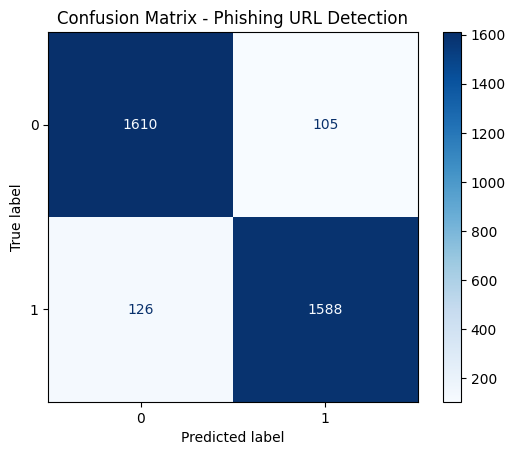

Confusion Matrix:
 [[1610  105]
 [ 126 1588]]


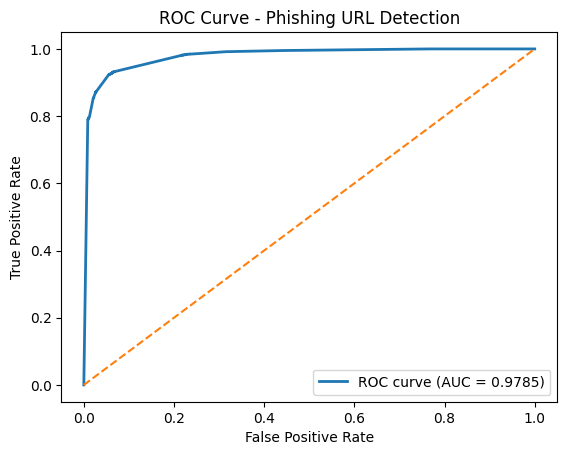

AUC Score: 0.9785


In [ ]:
# ==========================
# Evaluate on the 30% test split (no CONFIG['test_csv'])
# ==========================
import pandas as pd, re
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# --- Helpers (reuse existing ones if already defined) ---
try:
    norm_url
except NameError:
    def norm_url(u: str) -> str:
        if not isinstance(u, str):
            u = str(u)
        u = u.strip().lower()
        return re.sub(r'^https?://', '', u)

def _ensure_labels(series: pd.Series) -> np.ndarray:
    """Robust mapping to {0,1} supporting int labels and common strings."""
    s = series.copy()
    # If already 0/1 ints, keep them
    if pd.api.types.is_integer_dtype(s) and set(np.unique(s)).issubset({0, 1}):
        return s.astype(int).values
    # Map common string variants
    m = {
        "phishing": 1, "malicious": 1, "bad": 1,
        "legitimate": 0, "benign": 0, "good": 0
    }
    return s.astype(str).str.strip().str.lower().map(m).astype(int).values

# --- Use the test split created earlier: `test` ---
# (assumes you already ran the single-CSV 70/30 split cell that creates `train_full` and `test`)
test_df = test.copy().reset_index(drop=True)

# Ensure URL column for vectorizer
if "u" not in test_df.columns:
    if "url" not in test_df.columns:
        raise ValueError("Expected 'url' column in the test split.")
    test_df["u"] = test_df["url"].map(norm_url)

# Ensure label column (prefer 'label' if created; else fall back to 'status')
if "label" in test_df.columns:
    y_test = _ensure_labels(test_df["label"])
elif "status" in test_df.columns:
    y_test = _ensure_labels(test_df["status"])
else:
    raise ValueError("Expected a 'label' or 'status' column in the test split.")

# --- Vectorize & predict with your existing fitted objects: vec, cal ---
X_test = vec.transform(test_df["u"])
y_prob = cal.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Phishing URL Detection")
plt.show()
print("Confusion Matrix:\n", cm)

# --- ROC Curve & AUC ---
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Phishing URL Detection")
plt.legend(loc="lower right")
plt.show()

print(f"AUC Score: {roc_auc:.4f}")